In [1]:
%load_ext autoreload
%autoreload 2

import os
import wrds
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import datetime
from utils import summary_stats, stats_with_description, safe_last, match_gvkey, merge_df, find_consec_year, safe_div
import requests
from bs4 import BeautifulSoup
from soup2dict import convert
from urllib.parse import urljoin, urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import time
import zipfile
import pyreadstat
import itertools
from thefuzz import fuzz
from thefuzz import process
import re
import pickle


# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
CODING_TABLES_FOLDER = '.\\Coding_tables'
STATS_FOLDER = '.\\Stats'


if not os.path.exists(CHECKPOINT_FOLDER):
        os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(STATS_FOLDER):
        os.makedirs(STATS_FOLDER)

In [3]:
# connect
db = wrds.Connection(wrds_username = 'kglim')

Loading library list...
Done


In [279]:
sorted(db.list_libraries())

['aha_sample',
 'ahasamp',
 'audit',
 'audit_audit_comp',
 'audit_common',
 'auditsmp',
 'auditsmp_all',
 'block',
 'block_all',
 'boardex_trial',
 'boardsmp',
 'bvd',
 'bvd_orbis_large',
 'bvd_orbis_medium',
 'bvd_orbis_small',
 'calcbench_trial',
 'calcbnch',
 'cboe',
 'cboe_all',
 'ciq',
 'ciq_common',
 'ciq_ratings',
 'ciq_transcripts',
 'ciqsamp',
 'ciqsamp_common',
 'ciqsamp_keydev',
 'ciqsamp_transcripts',
 'columnar',
 'comp',
 'comp_bank',
 'comp_bank_daily',
 'comp_execucomp',
 'comp_global',
 'comp_global_daily',
 'comp_na_annual_all',
 'comp_na_daily_all',
 'comp_na_monthly_all',
 'comp_ratings',
 'comp_segments_hist',
 'comp_segments_hist_daily',
 'compa',
 'compb',
 'compg',
 'compm',
 'compsamp_snapshot',
 'compseg',
 'contrib',
 'contrib_ceo_turnover',
 'contrib_char_returns',
 'contrib_general',
 'contrib_intangible_value',
 'contrib_kpss',
 'contrib_liva',
 'crsp',
 'crsp_a_ccm',
 'crsp_a_indexes',
 'crsp_a_stock',
 'crsp_q_indexes',
 'crsp_q_indexhist',
 'crsp_q_mutu

In [69]:
sorted(db.list_tables(library='crsp_a_stock'))

['dse',
 'dseall',
 'dsedelist',
 'dsedist',
 'dseexchdates',
 'dsenames',
 'dsenasdin',
 'dseshares',
 'dsf',
 'dsf_v2',
 'dsfhdr',
 'dsi',
 'dsiy',
 'inddlyseriesdata',
 'indfamilyinfohdr',
 'indmthseriesdata',
 'indseriesinfohdr',
 'metacalendarperiod',
 'metacolumncoverage',
 'metacolumninfo',
 'metaexchangecalendar',
 'metafileinfo',
 'metaflagcoverage',
 'metaflaginfo',
 'metaflagtype',
 'metaiteminfo',
 'metasiztociz',
 'mse',
 'mseall',
 'msedelist',
 'msedist',
 'mseexchdates',
 'msenames',
 'msenasdin',
 'mseshares',
 'msf',
 'msf_v2',
 'msfhdr',
 'msi',
 'msiy',
 'saz_agg_ann',
 'saz_agg_mth',
 'saz_agg_qtr',
 'saz_del',
 'saz_dind',
 'saz_dis',
 'saz_dp_dly',
 'saz_ds_dly',
 'saz_hdr',
 'saz_indhdr',
 'saz_mdel',
 'saz_mind',
 'saz_mth',
 'saz_nam',
 'saz_ndi',
 'saz_shr',
 'stkannsecuritydata',
 'stkdelists',
 'stkdistributions',
 'stkdlysecuritydata',
 'stkdlysecurityprimarydata',
 'stkissuerinfohdr',
 'stkissuerinfohist',
 'stkmthfloatshares',
 'stkmthsecuritydata',
 'st

In [4]:
# useful commands


# sorted(db.list_libraries())

# sorted(db.list_tables(library='ibes'))

# db.get_row_count(library='wrdsapps', table='firm_ratio_ibes')

# db.describe_table(library='wrdsapps', table='firm_ratio_ibes')

# db.get_table(library='ibes', table='act_epsint', obs = 100)

# https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

### Download linking table CRSP <-> Compustat

For unique identifier look at:
https://libguides.stanford.edu/c.php?g=559845&p=6686228

and
https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/

Reference table is: https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/compustat-crsp-link/
Better run the query and download the data from the website, otherwise merge of multiple tables is required. Library is `'crsp_a_ccm'`

In [4]:
DATE_COLS = ['LINKDT', 'LINKENDDT', 'dldte', 'ipodate']    # columns to be converted into date
# MIN_DATE = '01/01/2000'                                  # minimum date for connection validity, applied to LINKDT
STRING_COLS = ['LPERMCO', 'LPERMNO']                       # columns to be converted to string

In [5]:
# read data and metadata

with zipfile.ZipFile(os.path.join(CODING_TABLES_FOLDER, 'link_table.zip')) as zf:
    df_link, meta = pyreadstat.read_dta(zf.extract("link_table.dta"))
    os.remove("link_table.dta")

# extract metadata and save variable description
col_descr = pd.DataFrame(meta.column_names_to_labels.items(), columns=['Variable Name', 'Description'])
col_descr.insert(1, 'Type', '')
col_descr.to_csv(os.path.join(CODING_TABLES_FOLDER, 'link_table.csv'), sep=';', index = False)

# convert dates
for col in DATE_COLS:
    df_link[col] = pd.to_datetime(df_link[col])
df_link.replace('NaT', np.nan)

# convert to string
for col in STRING_COLS:
    df_link[col] = df_link[col].fillna(-99)
    df_link[col] = df_link[col].astype(int).astype(str)
    df_link[col] = df_link[col].replace('-99', np.nan)

# filter by date
# df_link = df_link[df_link['LINKDT'] >= MIN_DATE]
    
print('\n- Database size:', df_link.shape)

df_link.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_link_raw.pkl'))

# stats
df_link_stats = stats_with_description(df_link, os.path.join(CODING_TABLES_FOLDER, 'link_table.csv'), col_to_lowercase=False)
df_link_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_link_raw_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_link_raw_stats.csv'))


- Database size: (99708, 47)

- Pickle saved to .\Checkpoints\df_link_raw.pkl

- Stats saved to .\Stats\00_df_link_raw_stats.csv


In [4]:
df_link = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_raw.pkl'))

Link Type can be:

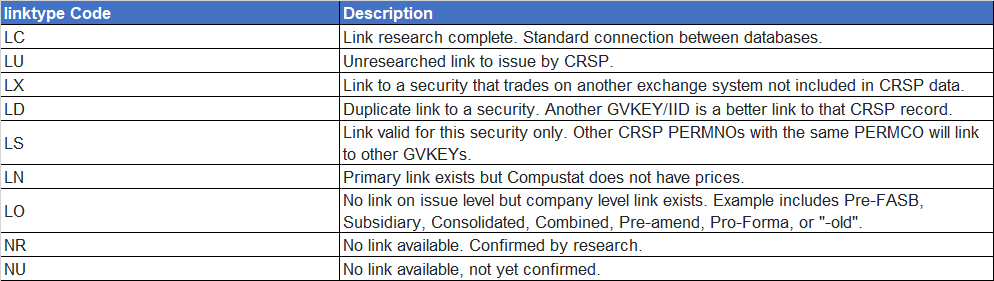


In [136]:
linktype = df_link.LINKTYPE.value_counts().to_frame()

print('-- Linktype count\n')
print(linktype)

print('\n-- Total missing for "LPERMCO" and "LPERMNO":\n', df_link_stats[df_link_stats['VARIABLE'].isin(['LPERMCO', 'LPERMNO'])][['VARIABLE','NANs']])

print('\n-- Sum of "NR" and "NU":', linktype[linktype.index.isin(['NU', 'NR'])].values.sum())

-- Linktype count

    LINKTYPE
NU     31548
NR     31425
LU     16003
LC     15339
LS      3988
LX      1108
LN       185
LD       112

-- Total missing for "LPERMCO" and "LPERMNO":
    VARIABLE           NANs
10  LPERMNO  62973 (63.2%)
11  LPERMCO  62973 (63.2%)

-- Sum of "NR" and "NU": 62973


`cusip` in `df_link_dict` are 9-digits. Must be converted to 8-digits for other tables. Export txt file and upload in https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/tools/cusip-converter/

save file as .dta

In [ ]:
CUSIP8_DTA = 'cusip_8digits.dta'

In [5]:
# save cusip-9 list

cusip_9_list = df_link.cusip.unique()
cusip_9_list = np.sort(cusip_9_list[cusip_9_list != ''])
np.savetxt(os.path.join(CODING_TABLES_FOLDER,'cusip_9digits.txt'), cusip_9_list, delimiter='\n', fmt='%s')
print('-- cusip list to upload saved to', os.path.join(CODING_TABLES_FOLDER,'cusip_9digits.txt'))

-- cusip list to upload saved to .\Coding_tables\cusip_9digits.txt


In [6]:
# read cusip-8 list and convert

cusip_conv, meta = pyreadstat.read_dta(os.path.join(CODING_TABLES_FOLDER, CUSIP8_DTA))
if cusip_conv.shape[0] != len(cusip_9_list):
    print('\n##### mismatch between cusip_9_list and cusip_8_list')

cusip_conv.rename(columns={'cusip': 'cusip8'}, inplace=True)
cusip_conv['cusip'] = cusip_9_list

matching_score = cusip_conv.apply(lambda x: fuzz.ratio(x['cusip8'], x['cusip']), axis = 1)
print('\n-- Fuzzy matching between cusip and cusip8 in range:', matching_score.min(), '-', matching_score.max())

if cusip_conv['cusip8'].nunique() != len(cusip_9_list):
    print('\n##### multiple cusip8 created')
    
df_link_final = df_link.copy().merge(cusip_conv, on='cusip', how='left')
missing_cusip_pre = df_link_final['cusip'].isna().sum() + (df_link_final['cusip'] == '').sum()
missing_cusip_post = df_link_final['cusip8'].isna().sum() + (df_link_final['cusip8'] == '').sum()
if missing_cusip_pre != missing_cusip_post:
    print('\n##### missing mismatch in cusip and cusip8')
df_link_final.rename(columns={'cusip': 'cusip9'}, inplace=True)
df_link_final.rename(columns={'cusip8': 'cusip'}, inplace=True)
move_col = df_link_final.pop('cusip')
df_link_final.insert(int(np.where(df_link_final.columns=='cusip9')[0][0]), 'cusip', move_col)

df_link_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_final.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_link_final.pkl'))

# stats
df_link_final_stats = stats_with_description(df_link_final, os.path.join(CODING_TABLES_FOLDER, 'link_table.csv'), col_to_lowercase=False)
df_link_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_link_final_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_link_final_stats.csv'))


-- Fuzzy matching between cusip and cusip8 in range: 94 - 94

- Pickle saved to .\Checkpoints\df_link_final.pkl

- Stats saved to .\Stats\00_df_link_final_stats.csv


In [251]:
df_link_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_final.pkl'))

In [8]:
# create a mapping with "gvkey" as key and other information as possible matching values

df_link_dict = df_link_final.copy().fillna('').groupby('gvkey').apply(lambda x: {'ticker': np.unique(x['tic'][x['tic'] != '']),
                                          'cusip': np.unique(x['cusip'][x['cusip'] != '']),
                                         'permno': np.unique(x['LPERMNO'][x['LPERMNO'] != '']),
                                         'permco': np.unique(x['LPERMCO'][x['LPERMCO'] != '']),
                                         'name': np.unique(x['conm'])}).reset_index(name = 'link_info')


df_link_dict.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_dict.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_link_dict.pkl'))


- Pickle saved to .\Checkpoints\df_link_dict.pkl


## Download Monthly Stocks

Reference page:
https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/monthly-stock-file/

For unique identifier look at:
https://libguides.stanford.edu/c.php?g=559845&p=6686228

In [306]:
# LIB = 'crsp_a_stock'
# TAB = 'msf'
# MIN_DATE = '01/01/2005'
# DATE_FILTER = 'date'                          # date to be used for filtering
# DATE_COLS = ['date', 'altprcdt']              # columns to be converted into date
# STRING_COLS = ['permno', 'permco']                       # columns to be converted to string

In [302]:
# get column list

# pd.set_option('display.max_rows', 100)
# db.describe_table(library=LIB, table=TAB)

Approximately 4834487 rows in crsp_a_stock.msf.


,name,nullable,type,comment
0,cusip,True,VARCHAR(8),CUSIP Header
1,permno,True,DOUBLE_PRECISION,PERMNO
2,permco,True,DOUBLE_PRECISION,PERMCO
3,issuno,True,DOUBLE_PRECISION,Nasdaq Issue Number
4,hexcd,True,DOUBLE_PRECISION,Exchange Code Header
5,hsiccd,True,DOUBLE_PRECISION,Standard Industrial Classification Code
6,date,True,DATE,Date of Observation
7,bidlo,True,DOUBLE_PRECISION,Bid or Low Price
8,askhi,True,DOUBLE_PRECISION,Ask or High Price
9,prc,True,DOUBLE_PRECISION,Price or Bid/Ask Average


In [310]:
# download data
# query = [
#     " select * from " + LIB + "." + TAB,
#     "where " + DATE_FILTER + ">='" + MIN_DATE +"'"
# ]

# print('- Query:\n', '\n'.join(query))

# start = timer()
# print('\n\nQuerying...', end='')
# df_stock = db.raw_sql('\n'.join(query), date_cols=DATE_COLS)
# print(' Total elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
# print('\n- Database size:', df_stock.shape)

# convert to string
# for col in STRING_COLS:
#     df_stock[col] = df_stock[col].fillna(-99)
#     df_stock[col] = df_stock[col].astype(int).astype(str)
#     df_stock[col] = df_stock[col].replace('-99', np.nan)


# df_stock.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'), protocol=-1)
# print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'))

# # stats
# df_stock_stats = stats_with_description(df_stock, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
# df_stock_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_stock_raw_stats.csv'), index=False, sep=';')
# print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_stock_raw_stats.csv'))

- Query:
  select * from crsp_a_stock.msf
where date>='01/01/2005'


Querying... Total elapsed time: 0:01:03

- Database size: (1508192, 21)

- Pickle saved to .\Checkpoints\df_stock_raw.pkl

- Stats saved to .\Stats\00_df_stock_raw_stats.csv


In [17]:
DATE_COLS = ['date', 'nameendt']                      # columns to be converted to date
STRING_COLS = ['permno', 'permco']                    # columns to be converted to string

In [77]:
# read data and metadata

with zipfile.ZipFile(os.path.join(CODING_TABLES_FOLDER, 'df_stock.zip')) as zf:
    df_stock, meta = pyreadstat.read_dta(zf.extract("df_stock.dta"))
    os.remove("df_stock.dta")
    df_stock.columns = df_stock.columns.str.lower()

# extract metadata and save variable description
col_descr = pd.DataFrame(meta.column_names_to_labels.items(), columns=['Variable Name', 'Description'])
col_descr.insert(1, 'Type', '')
col_descr.to_csv(os.path.join(CODING_TABLES_FOLDER, 'df_stock.csv'), sep=';', index = False)

# convert dates
for col in DATE_COLS:
    df_stock[col] = pd.to_datetime(df_stock[col])
df_stock.replace('NaT', np.nan)

# convert to string
for col in STRING_COLS:
    df_stock[col] = df_stock[col].fillna(-99)
    df_stock[col] = df_stock[col].astype(int).astype(str)
    df_stock[col] = df_stock[col].replace('-99', np.nan)

# remove empty rows
df_stock = df_stock[df_stock['ncusip'] != '']
    
print('\n- Database size:', df_stock.shape)

df_stock.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'))

# stats
df_stock_stats = stats_with_description(df_stock, os.path.join(CODING_TABLES_FOLDER, 'df_stock.csv'))
df_stock_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_stock_raw_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_stock_raw_stats.csv'))


- Database size: (1499174, 21)

- Pickle saved to .\Checkpoints\df_stock_raw.pkl

- Stats saved to .\Stats\00_df_stock_raw_stats.csv


In [22]:
df_stock.head(8)

,permno,date,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,tsymbol,naics,permco,issuno,hexcd,hsiccd,cusip,hsicmg,hsicig,vol,ret
0,10001,2005-01-31,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,515.0,-0.040580
1,10001,2005-02-28,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,726.0,-0.045166
2,10001,2005-03-31,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,4107.0,0.124822
3,10001,2005-04-29,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,527.0,-0.074684
4,10001,2005-05-31,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,1990.0,0.219030
5,10001,2005-06-30,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,10615.0,0.128429
6,10001,2005-07-29,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,2422.0,0.009945
7,10001,2005-08-31,NaT,11.0,3.0,4920.0,29274A10,EWST,ENERGY WEST INC,,EWST,221210,7953,10398.0,2.0,4925.0,36720410,NaN,NaN,2610.0,0.039387


In [23]:
df_stock = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'))

## Download Earnings Per Share

Reference page:
https://wrds-www.wharton.upenn.edu/pages/get-data/ibes-thomson-reuters/ibes-academic/detail-history/actuals/

For unique identifier look at:
https://libguides.stanford.edu/c.php?g=559845&p=6686228

In [4]:
LIB = 'ibes'
TAB = ['act_epsint', 'act_epsus']
MIN_DATE = '01/01/2005'
FREQ = 'ANN'                                   # frequency of data 'ANN', 'QRT', 'SAN'
DATE_FILTER = 'pends'                          # date to be used for filtering
DATE_COLS = ['pends', 'anndats', 'actdats']    # columns to be converted into date
HOURS_COLS = ['anntims', 'acttims']            # columns to be converted into hours, minutes, seconds

In [6]:
# get column list

pd.set_option('display.max_rows', 100)
db.describe_table(library=LIB, table=TAB[0])

Approximately 3024818 rows in ibes.act_epsint.


,name,nullable,type,comment
0,ticker,True,VARCHAR(6),None
1,cusip,True,VARCHAR(8),None
2,oftic,True,VARCHAR(6),None
3,cname,True,VARCHAR(16),None
4,pends,True,DATE,None
5,measure,True,VARCHAR(6),None
6,pdicity,True,VARCHAR(3),None
7,anndats,True,DATE,None
8,anntims,True,DOUBLE_PRECISION,None
9,actdats,True,DATE,None


In [5]:
# download data

df_EPS = pd.DataFrame()
for tb in TAB:
    
    print('-- Downloading ', tb, '\n')
    query = [
        " select * from " + LIB + "." + tb,
        "where " + DATE_FILTER + ">='" + MIN_DATE +"' and pdicity='" + FREQ + "'"
    ]

    print('- Query:\n', '\n'.join(query))

    start = timer()
    print('\n\nQuerying...', end='')
    df_t = db.raw_sql('\n'.join(query), date_cols=DATE_COLS + HOURS_COLS)
    print(' Elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
    print('  Total rows:', df_t.shape[0], '\n\n')
    df_EPS = df_EPS.append(df_t)
    del df_t

# convert times to hours, minutes, seconds
for col in HOURS_COLS:
    df_EPS[col] = df_EPS[col].dt.strftime('%H:%M:%S')
    
print('\n- Database size:', df_EPS.shape)

df_EPS.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'))

# stats
df_EPS_stats = stats_with_description(df_EPS, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB[0] + '.csv'))
df_EPS_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_EPS_raw_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_EPS_raw_stats.csv'))

-- Downloading  act_epsint 

- Query:
  select * from ibes.act_epsint
where pends>='01/01/2005' and pdicity='ANN'


Querying... Elapsed time: 0:01:31
  Total rows: 513120 


-- Downloading  act_epsus 

- Query:
  select * from ibes.act_epsus
where pends>='01/01/2005' and pdicity='ANN'


Querying... Elapsed time: 0:00:12
  Total rows: 106848 



- Database size: (619968, 14)

- Pickle saved to .\Checkpoints\df_EPS_raw.pkl

- Stats saved to .\Stats\00_ibes_EPS_raw_stats.csv


In [5]:
df_EPS = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_raw.pkl'))

In [6]:
# check usfirm
# USFIRM=0 if from .INT, and USFIRM=1 if from .US file

display(df_EPS.usfirm.value_counts().to_frame())

check_usfirm = df_EPS.groupby('cusip')['usfirm'].nunique().to_frame()
check_usfirm_multi = check_usfirm[check_usfirm['usfirm'] > 1]
print('-', check_usfirm_multi.shape[0], 'firms with multiple "usfirm". Check "check_usfirm_multi"')
# df_EPS[df_EPS.cusip == "9891391X"].sort_values(by=['pends'])

,usfirm
0.0,513120
1.0,106848


- 108 firms with multiple "usfirm". Check "check_usfirm_multi"


,Tot_NA,Tot_obs,perc,valid_obs
measure,,,,
EPS,144449,507581,28.46,363132
EPSPAR,38175,112387,33.97,74212


C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


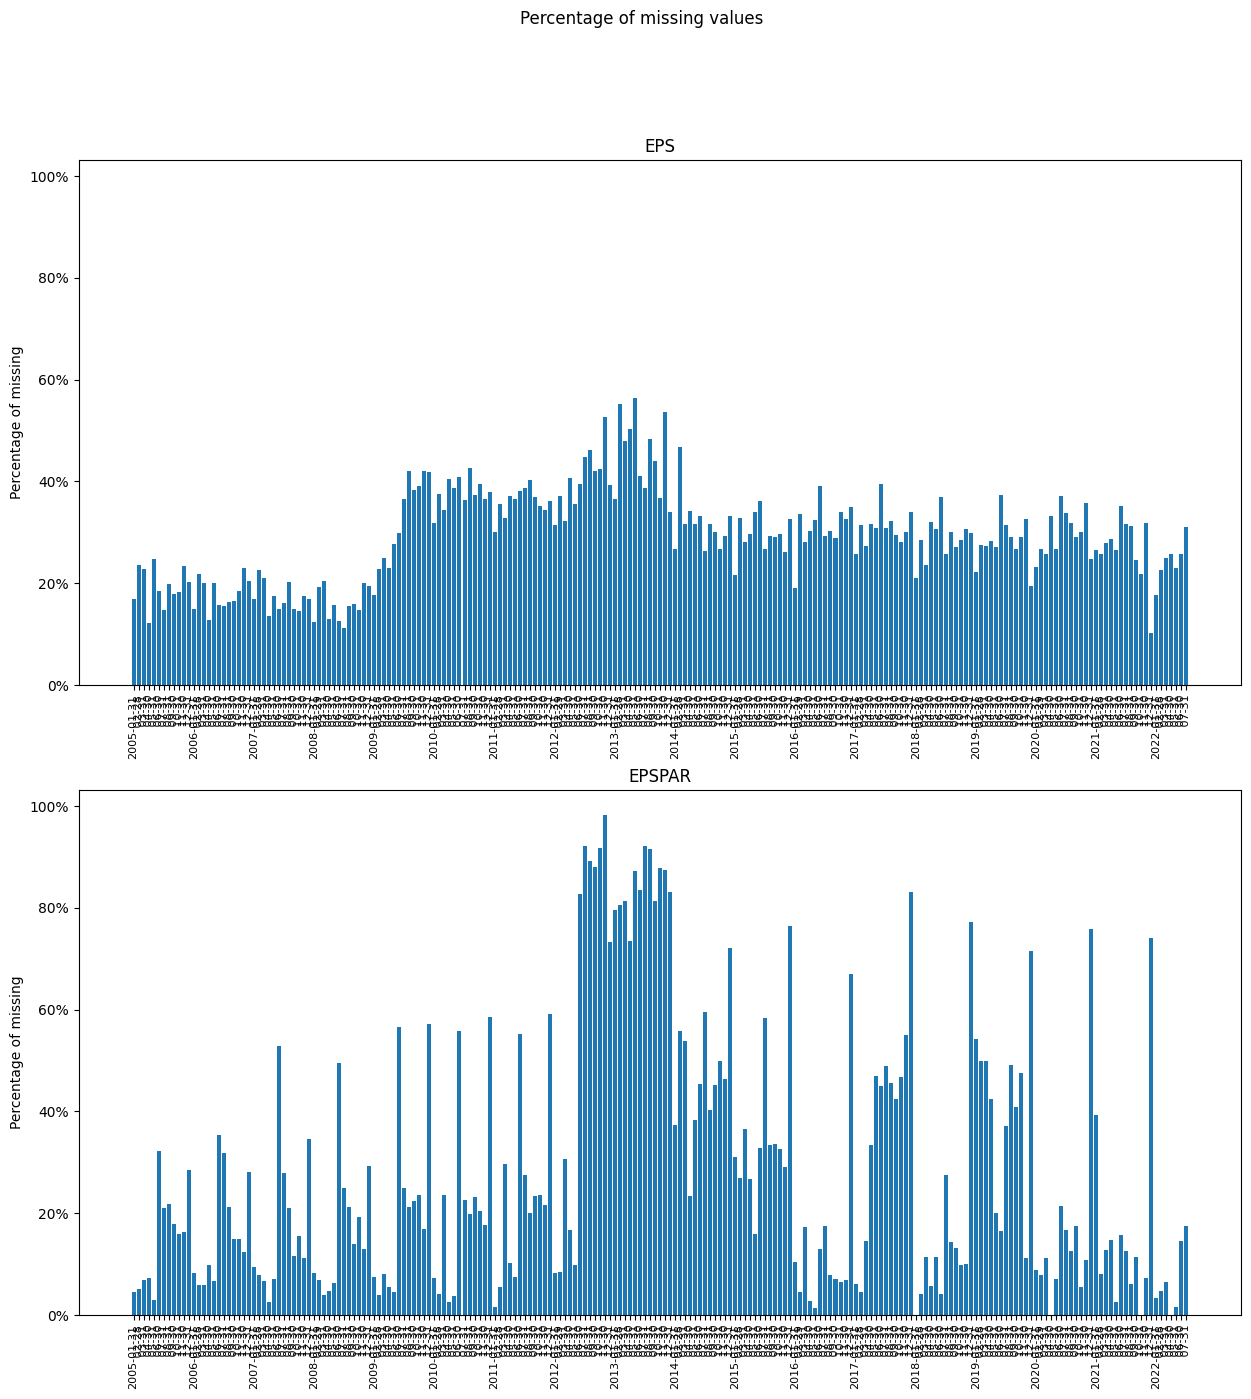

In [7]:
# check ESP and EPSPAR

display(
        df_EPS.groupby('measure').agg(
        Tot_NA=('value', lambda x: np.isnan(x).sum()),
        Tot_obs=('value', lambda x: len(x))
    ).assign(
        perc = lambda x: np.round(x.Tot_NA / x.Tot_obs * 100, 2),
        valid_obs = lambda x: x.Tot_obs - x.Tot_NA
    )
)

# plot missing percentage

plot_data = df_EPS.groupby(['pends', 'measure']).agg(
    Tot_NA=('value', lambda x: np.isnan(x).sum()),
    Tot_obs=('value', lambda x: len(x))
).reset_index().assign(
    perc = lambda x: np.round(x.Tot_NA / x.Tot_obs * 100, 2)
)#.set_index('pends')
plot_data['pends'] = pd.to_datetime(plot_data['pends']).dt.strftime('%Y-%m-%d')

fig, ax = plt.subplots(2, 1, figsize=(15, 15), sharey=True, sharex=False)
ax = ax.flatten()
ax_c = 0

for meas in plot_data['measure'].unique():

    dd = plot_data[plot_data['measure'] == meas].sort_values(by=['pends'])[['pends', 'perc']]
    labels = [time.strptime(x, '%Y-%m-%d') for x in dd.pends.values]
    labels = [time.strftime('%Y-%m-%d', x) if x.tm_mon == 1 else time.strftime('     %m-%d', x) for x in labels]
    ax[ax_c].bar(dd['pends'], dd['perc'])
    ax[ax_c].tick_params(axis='x', labelrotation=90, labelsize = 8)
    ax[ax_c].set_xticklabels(labels)
    ax[ax_c].set_title(meas)
    ax[ax_c].set_ylabel('Percentage of missing')
    ax[ax_c].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_c += 1
fig.suptitle('Percentage of missing values')
plt.show()

### Filter for non missing EPS and multiple ticker and activation date

In [6]:
df_EPS_final = df_EPS.copy()
df_EPS_final = df_EPS_final.assign(
    year = lambda x: x.pends.astype('datetime64[D]').dt.strftime('%Y').astype(int),
    announce = lambda x: pd.to_datetime(x.anndats.astype('datetime64[D]').dt.strftime('%Y-%m-%d') + ' ' + x.anntims),
    activation = lambda x: pd.to_datetime(x.actdats.astype('datetime64[D]').dt.strftime('%Y-%m-%d') + ' ' + x.acttims)
)
df_EPS_final = df_EPS_final[df_EPS_final['measure'] == 'EPS']
df_EPS_final = df_EPS_final[~df_EPS_final['value'].isnull()]
df_EPS_final = df_EPS_final[~df_EPS_final['cname'].isnull()]
df_EPS_final = df_EPS_final[df_EPS_final['cusip'] != '00000000']
df_EPS_final.drop(columns=['measure', 'pdicity', 'anndats', 'anntims', 'actdats', 'acttims'], inplace=True)
df_EPS_final.head(8)

,ticker,cusip,oftic,cname,pends,value,curr_act,usfirm,year,announce,activation
2,0003,66515910,FFF,NORTH FRONTIER,2014-12-31,-0.16,CAD,0.0,2014,2015-03-19 17:01:00,2015-03-19 18:01:49
3,0003,66515910,FFF,NORTH FRONTIER,2015-12-31,-0.22,CAD,0.0,2015,2016-03-14 09:00:00,2016-03-14 09:11:05
8,001V,03702510,ATE,ANTIBE,2018-03-31,-0.50,CAD,0.0,2018,2018-06-29 16:00:00,2018-06-29 17:38:20
9,001V,03702510,ATE,ANTIBE,2019-03-31,-0.60,CAD,0.0,2019,2019-07-16 19:35:00,2019-07-16 19:43:16
10,001V,03702510,ATE,ANTIBE,2020-03-31,-0.70,CAD,0.0,2020,2020-07-24 18:17:00,2020-07-24 18:39:49
11,001V,03702550,ATE,ANTIBE,2021-03-31,-0.69,CAD,0.0,2021,2021-06-28 11:50:00,2021-06-29 06:06:26
12,001V,03702550,ATE,ANTIBE,2022-03-31,-0.50,CAD,0.0,2022,2022-06-28 20:00:00,2022-07-02 13:27:54
15,001W,46111Q10,IT,INTERTAIN GROUP,2014-12-31,0.82,CAD,0.0,2014,2015-03-09 16:27:00,2015-03-09 18:07:13


In [7]:
# check ticker

check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('Group by "cusip", count of "ticker" (IBES ticker):\n', check_ticker['ticker'].value_counts().to_frame())

print('\n\n--- Removing multiple ticker')
cusip_mult = check_ticker[check_ticker['ticker'] > 1]['cusip'].values
df_EPS_final = df_EPS_final[~df_EPS_final['cusip'].isin(cusip_mult)]
check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('\nGroup by "cusip", count of "ticker" (IBES ticker):\n', check_ticker['ticker'].value_counts().to_frame())

print('\n--- Removing multiple announce date (take last)')
df_EPS_final = df_EPS_final.sort_values(by=['activation']).groupby(['ticker', 'year']).last().reset_index()
check_year = df_EPS_final.groupby('ticker').agg(
    duplicates=('year', lambda x: len(x) - len(np.unique(x)))
).reset_index()
print('\nGroup by "ticker", count of duplicated "year":\n', check_year['duplicates'].value_counts().to_frame())

check_ticker = df_EPS_final.groupby('cusip')['ticker'].nunique().to_frame().reset_index()
print('\n\nGroup by "cusip", count of "ticker":\n', check_ticker['ticker'].value_counts().to_frame())
check_cusip = df_EPS_final.groupby('ticker')['cusip'].nunique().to_frame().reset_index()
print('\nGroup by "ticker", count of "cusip" (cusip may change over years):\n', check_cusip['cusip'].value_counts().to_frame())
check_oftic = df_EPS_final.groupby('cusip')['oftic'].nunique().to_frame().reset_index()
print('\nGroup by "cusip", count of "oftic" (cusip may change over years):\n', check_oftic['oftic'].value_counts().to_frame())

print('\n\n--- "ticker" is the unique identifier for each company.', df_EPS_final['ticker'].nunique(), 'found.')
print('\n--- "cusip" is the matching key.', df_EPS_final['cusip'].nunique(), 'found.')

df_EPS_final_stats = stats_with_description(df_EPS_final, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB[0] + '.csv'))
df_EPS_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_EPS_final_stats.csv'), index=False, sep=';')
print('\n--- Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_EPS_final_stats.csv'))

print('\n--- Matching "gvkey"')
df_link_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_final.pkl'))
df_EPS_final = match_gvkey(df_EPS_final.copy(), df_link_final, col_to_check = ['cusip'])

df_EPS_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl'), protocol=-1)
print('\n--- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl'))

Group by "cusip", count of "ticker" (IBES ticker):
    ticker
1   58218
2     135


--- Removing multiple ticker

Group by "cusip", count of "ticker" (IBES ticker):
    ticker
1   58218

--- Removing multiple announce date (take last)

Group by "ticker", count of duplicated "year":
    duplicates
0       51443


Group by "cusip", count of "ticker":
    ticker
1   58215

Group by "ticker", count of "cusip" (cusip may change over years):
     cusip
1   45879
2    4638
3     728
4     153
5      28
8       5
7       5
6       5
9       1
10      1

Group by "cusip", count of "oftic" (cusip may change over years):
    oftic
1  53501
2   4003
0    368
3    321
4     21
5      1


--- "ticker" is the unique identifier for each company. 51443 found.

--- "cusip" is the matching key. 58215 found.

--- Stats saved to .\Stats\00_ibes_EPS_final_stats.csv

--- Matching "gvkey"
Total elapsed time: 0:02:17

- Matching procedure:


,match_type,count
0,[],282932
1,[cusip],71031



- Multiple gvkey count:


,tot_gvkey,count
0,0,282932
1,1,71031



--- Pickle saved to .\Checkpoints\df_EPS_final.pkl


In [42]:
df_EPS_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl'))

## Download financial ratios (with IBES subscription)

Reference page:
https://wrds-www.wharton.upenn.edu/pages/get-data/financial-ratios-suite-wrds/financial-ratios-with-ibes-subscription/financial-ratios-firm-level-ibes/

For variable definition look at bottom of: https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/wrds-financial-ratios/financial-ratios-sas-code/
and relative macros at https://github.com/jcizel/WRDS-SAS-UTILITIES/tree/master/wrdsmacros 

For unique identifier look at:
https://libguides.stanford.edu/c.php?g=559845&p=6686228

In [4]:
LIB = 'wrdsapps'
TAB = 'firm_ratio_ibes'
MIN_DATE = '01/01/2005'
DATE_FILTER = 'public_date'                      # date to be used for filtering
DATE_COLS = ['public_date', 'adate', 'qdate']    # columns to be converted into date
SECTOR_COLS = ['gsector', 'gicdesc', 'ffi5_desc', 'ffi5', 'ffi10_desc', 'ffi10', 'ffi12_desc', 'ffi12', 'ffi17_desc',
              'ffi17', 'ffi30_desc', 'ffi30', 'ffi38_desc', 'ffi38', 'ffi48_desc', 'ffi48', 'ffi49_desc', 'ffi49'] # columns to be converted to string

In [89]:
# get column list
pd.set_option('display.max_rows', 100)
db.describe_table(library=LIB, table=TAB)

Approximately 2703490 rows in wrdsapps.firm_ratio_ibes.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),None
1,permno,True,DOUBLE_PRECISION,None
2,adate,True,DATE,None
3,qdate,True,DATE,None
4,public_date,True,DATE,None
5,capei,True,DOUBLE_PRECISION,None
6,be,True,DOUBLE_PRECISION,None
7,bm,True,DOUBLE_PRECISION,None
8,evm,True,DOUBLE_PRECISION,None
9,pe_op_basic,True,DOUBLE_PRECISION,None


In [7]:
# download data
query = [
    " select * from " + LIB + "." + TAB,
    "where " + DATE_FILTER + ">='" + MIN_DATE +"'"    
]

print('- Query:\n', '\n'.join(query))

start = timer()
print('\n\nQuerying...', end='')
df_ratios = db.raw_sql('\n'.join(query), date_cols=DATE_COLS)
first_cols = ['gvkey', 'permno', 'ticker', 'cusip'] + DATE_COLS
df_ratios = df_ratios[first_cols + [x for x in df_ratios.columns if x not in first_cols]]
print(' Total elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
print('\n- Database size:', df_ratios.shape)

# convert to string and replace None with Blank
for col in SECTOR_COLS:
    if df_ratios[col].dtype == object:
        df_ratios[col] = df_ratios[col].fillna('')
    else:
        df_ratios[col] = df_ratios[col].fillna(-99).astype(int).astype(str).replace('-99', '')


df_ratios.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'))

# stats
df_ratios_stats = stats_with_description(df_ratios, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_ratios_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_firmratio_raw_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_firmratio_raw_stats.csv'))

- Query:
  select * from wrdsapps.firm_ratio_ibes
where public_date>='01/01/2005'


Querying... Total elapsed time: 0:03:12

- Database size: (794882, 100)

- Pickle saved to .\Checkpoints\df_ratios_raw.pkl

- Stats saved to .\Stats\00_ibes_firmratio_raw_stats.csv


In [4]:
df_ratios = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_raw.pkl'))

### Clean the dataset

In [9]:
# check data e recover missing cusip and ticker (used as link with EPS)

start = timer()
missing_cusip = df_ratios[df_ratios['cusip'].isna()]['gvkey'].unique()
df_missing_cusip=df_ratios.copy()[df_ratios['gvkey'].isin(missing_cusip)]
print('--- "gvkey" with missing cusip:', len(missing_cusip))

df_ratios_final = df_ratios.copy().sort_values(by='public_date')
# df_ratios_final.insert(3, 'cusip_orig', df_ratios_final['cusip'])
# df_ratios_final.insert(2, 'ticker_orig', df_ratios_final['ticker'])

for val in ['cusip', 'ticker']:

    print('\n---', val, 'missing rows:', df_ratios_final[val].isna().sum())

    for way in ['forward', 'backward']:
        for date in ['qdate', 'adate']:

            if way == 'forward':
                ref = df_ratios_final.groupby(['gvkey', date])[val].last()
            else:
                ref = df_ratios_final.groupby(['gvkey', date])[val].first()
            ref = ref.reset_index().rename(columns={val: 'val_new'})

            df_ratios_final = df_ratios_final.merge(ref, on =['gvkey', date], how='left')
            df_ratios_final[val].fillna(df_ratios_final['val_new'], inplace=True)
            df_ratios_final.drop(columns=['val_new'], inplace=True)

            print(way, date, df_ratios_final[val].isna().sum())
            
# check duplicated rows
if df_ratios_final.groupby(['gvkey', 'public_date'])['gvkey'].count().to_frame().max()[0] > 1:
    print('\n#### warning: duplicated "gvkey", "public_date" found!')
    
# check industrial sector
print('\n--- Recovering industrial sector (take last available)')
sector_col = ['gsector', 'gicdesc', 'ffi5_desc', 'ffi5', 'ffi10_desc', 'ffi10', 'ffi12_desc', 'ffi12', 'ffi17_desc',
              'ffi17', 'ffi30_desc', 'ffi30', 'ffi38_desc', 'ffi38', 'ffi48_desc', 'ffi48', 'ffi49_desc', 'ffi49']
    
sector_duplicates_pre = df_ratios_final[['gvkey'] + sector_col].groupby('gvkey').nunique()
sector_missing_pre = df_ratios_final[['gvkey'] + sector_col].groupby('gvkey').agg(lambda x: (x == '').sum())
df_ratios_final.sort_values(by='public_date', inplace=True)
for col in sector_col:
    df_ratios_final[col] = df_ratios_final.groupby('gvkey')[col].transform(safe_last)
sector_duplicates_post = df_ratios_final[['gvkey'] + sector_col].groupby('gvkey').nunique()
sector_missing_post = df_ratios_final[['gvkey'] + sector_col].groupby('gvkey').agg(lambda x: (x == '').sum())

for col in sector_col:
    print('   ', (col + ':').ljust(15), 'duplicates', (sector_duplicates_pre[col] > 1).sum(), '->', (sector_duplicates_post[col] > 1).sum(),
         '     missing', (sector_missing_pre[col] > 1).sum(), '->', (sector_missing_post[col] > 1).sum())
    

# fill missing ratios with last available value (by public_date)
notfill_cols = ['gvkey', 'permno', 'ticker', 'cusip', 'public_date', 'adate', 'qdate'] + sector_col
fill_cols = [x for x in df_ratios_final.columns if x not in notfill_cols]
print('\n--- Filling missing ratios by taking last available information (by "public_date")')
print('   Before:', df_ratios_final[fill_cols].isna().sum().sum())
df_ratios_final[fill_cols] = df_ratios_final.sort_values(by='public_date').groupby('gvkey')[fill_cols].ffill()
print('   After:', df_ratios_final[fill_cols].isna().sum().sum())   
print('\n\nTotal elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))

df_ratios_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_final.pkl'), protocol=-1)
print('\n--- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_ratios_final.pkl'))

# stats
df_ratios_final_stats = stats_with_description(df_ratios_final, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_ratios_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_ibes_firmratio_final_stats.csv'), index=False, sep=';')
print('\n--- Stats saved to', os.path.join(STATS_FOLDER, '00_ibes_firmratio_final_stats.csv'))

--- "gvkey" with missing cusip: 2447

--- cusip missing rows: 3752
forward qdate 3734
forward adate 1209
backward qdate 1209
backward adate 1209

--- ticker missing rows: 15627
forward qdate 15609
forward adate 11189
backward qdate 11183
backward adate 11168

--- Recovering industrial sector (take last available)
    gsector:        duplicates 1523 -> 0      missing 705 -> 291
    gicdesc:        duplicates 1523 -> 0      missing 705 -> 291
    ffi5_desc:      duplicates 641 -> 0      missing 5 -> 0
    ffi5:           duplicates 641 -> 0      missing 5 -> 0
    ffi10_desc:     duplicates 696 -> 0      missing 5 -> 0
    ffi10:          duplicates 696 -> 0      missing 5 -> 0
    ffi12_desc:     duplicates 813 -> 0      missing 5 -> 0
    ffi12:          duplicates 813 -> 0      missing 5 -> 0
    ffi17_desc:     duplicates 850 -> 0      missing 622 -> 343
    ffi17:          duplicates 850 -> 0      missing 622 -> 343
    ffi30_desc:     duplicates 920 -> 0      missing 625 -> 331
   

In [4]:
df_ratios_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_final.pkl'))

### Select rows corresponding to Fiscal Year End and link EPS

In [5]:
MIN_CONSECUTIVE_YEARS = 2  # mininum consecutive years to keep (will be used to evaluate lagged INPUT features)

In [8]:
# load EPS and decrease year for matching
df_EPS_final_match = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_EPS_final.pkl')).assign(year = lambda x: x.year - 1)

df_ratios_annual = df_ratios_final.copy().groupby('gvkey', as_index=False).apply(
    lambda g: g[g['public_date'].isin(g['adate'])]).drop(columns=['qdate']).droplevel(0)

df_ratios_annual = df_ratios_annual.assign(
    year = lambda x: x.public_date.astype('datetime64[D]').dt.strftime('%Y').astype(int)
)
df_ratios_annual['permno'] = df_ratios_annual['permno'].astype(int).astype(str)

# take latest public_date for every year
check_multiple_year = df_ratios_annual.groupby(['gvkey', 'year']).agg(cc=('year', lambda x: len(x))).query('cc > 1')
if check_multiple_year.shape[0] > 0:
    prev_row = df_ratios_annual.shape[0]
    df_ratios_annual=df_ratios_annual.sort_values(by='public_date').groupby(['gvkey', 'year']).tail(1)
    print('\n--- Removed', prev_row - df_ratios_annual.shape[0], 'rows because of multiple years. Taken latest "public_date"')
    check_multiple_year = df_ratios_annual.groupby(['gvkey', 'year']).agg(cc=('year', lambda x: len(x))).query('cc > 1')
    if check_multiple_year.shape[0] > 0:
        print('  ########   duplicated years still present')
        
# match gvkey
print('\n--- Matching "gvkey"')
df_link_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_link_final.pkl'))
df_ratios_annual = match_gvkey(df_ratios_annual.copy().rename(columns={'gvkey': 'gvkey_original'}), df_link_final, col_to_check = ['permno'])
if sum(df_ratios_annual['gvkey_tot'] == 0) > 0:
    print('\n- Dropped rows because of missing matched gvkey:', sum(df_ratios_annual['gvkey_tot'] == 0))
    df_ratios_annual = df_ratios_annual[df_ratios_annual['gvkey_tot'] > 0]
    
# merge EPS values
df_ratios_annual, ref_tab_df_ratios_annual = merge_df(df_left=df_ratios_annual.copy(), df_right=df_EPS_final_match.copy(),
                                                      left_on_key = 'year', right_on_key = 'year', right_columns = ['year', 'value'],
                                                      duplicated_groupby_check = 'year')
df_ratios_annual = df_ratios_annual.rename(columns={'value': 'EPS_next_year'})
first_cols = ['xxx_ID', 'gvkey', 'match_type', 'gvkey_tot', 'gvkey_original', 'permno', 'ticker', 'cusip', 'public_date', 'adate', 'year']
df_ratios_annual = df_ratios_annual[first_cols + [x for x in df_ratios_annual.columns if x not in first_cols]]
print('\n--- Unmatched gvkey:', df_ratios_annual.xxx_ID.isna().sum())
print('\n--- Unmatched/missing EPS:', df_ratios_annual.EPS_next_year.isna().sum(), '/', df_ratios_annual.shape[0],
      'rows. Remaining:', df_ratios_annual.shape[0] - df_ratios_annual.EPS_next_year.isna().sum())

# save company names and reference
print('\n--- Saving reference table for unique ID "xxx_ID" and company name in', os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual_ref.pkl'))
df_names, ref_tab_names = merge_df(df_left=df_ratios_annual.copy().drop(columns='xxx_ID'), df_right=df_EPS_final_match.copy(),
                  left_on_key = [], right_on_key = [], right_columns = ['cname'], check_duplicates_right=False, warn=False)
df_ratios_annual_names=df_names[['xxx_ID', 'cname']].groupby('xxx_ID', as_index=False).agg(name=('cname', lambda x: np.unique(x[~x.isnull()]).tolist())).rename(columns={'xxx_ID': 'xxx_ID_names'})
common_keys = set(ref_tab_names.keys()) & set(ref_tab_df_ratios_annual.keys())
if len(common_keys) != len(ref_tab_names):
    print('\n##### missing unique ID "xxx_ID" in ref_tab_names')
# remap xxx_ID from ref_tab_df_ratios_annual on ref_tab_names
df_ratios_annual_names = pd.DataFrame(ref_tab_df_ratios_annual.items(), columns=['gvkey', 'xxx_ID']).merge(
    pd.DataFrame(ref_tab_names.items(), columns=['gvkey', 'xxx_ID_names']), on='gvkey', how='left').merge(
    df_ratios_annual_names, on='xxx_ID_names', how='left').drop(columns='xxx_ID_names')
with open(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual_ref.pkl'), 'wb') as handle:
    pickle.dump({'ref_tab': ref_tab_df_ratios_annual, 'comp_names': df_ratios_annual_names}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# mark consecutive years rows to keep
df_ratios_annual = df_ratios_annual.copy().sort_values(by='year').groupby('xxx_ID').apply(find_consec_year, min_consecutive_years = MIN_CONSECUTIVE_YEARS, year_col = 'year', col_na_check = 'EPS_next_year')
print('\n--- Rows valid for a minimum of', MIN_CONSECUTIVE_YEARS, 'consecutive years:', df_ratios_annual.consec_year.sum())
print('    corresponding to ',
      df_ratios_annual[['xxx_ID', 'consec_year_group']][df_ratios_annual['consec_year_group'] != -1].groupby(['xxx_ID', 'consec_year_group']).agg(valid_obs=('consec_year_group', lambda x: len(x)-(MIN_CONSECUTIVE_YEARS-1)))['valid_obs'].sum(),
     'valid observations with', MIN_CONSECUTIVE_YEARS-1, 'lagged years')
print('    use "consec_year" to filter out valid observation')
first_cols = list(df_ratios_annual.columns[:np.where(df_ratios_annual.columns == 'year')[0][0]+1]) + ['consec_year' ,'consec_year_group']
df_ratios_annual = df_ratios_annual[first_cols + [x for x in df_ratios_annual.columns if x not in first_cols]]

# save dataset
df_ratios_annual.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual.pkl'), protocol=-1)
print('\n--- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual.pkl'))


--- Removed 45 rows because of multiple years. Taken latest "public_date"

--- Matching "gvkey"
Total elapsed time: 0:00:13

- Matching procedure:


,match_type,count
0,[],5
1,[permno],61726



- Multiple gvkey count:


,tot_gvkey,count
0,1,58740
1,2,2852
2,3,134
3,0,5



- Multiple gvkey with shared values: 1

- Dropped rows because of missing matched gvkey: 5
- Removed rows from df_left because of multiple unique ID on same gvkey_original: 34

-- dropping duplicated values in df_left for "year" - duplicates are evaluated according to "gvkey_original"

-- dropping duplicated values in df_right for "year" - duplicates are evaluated according to "gvkey"

--- Unmatched gvkey: 0

--- Unmatched/missing EPS: 19910 / 61438 rows. Remaining: 41528

--- Saving reference table for unique ID "xxx_ID" and company name in .\Checkpoints\df_ratios_annual_ref.pkl

--- Rows valid for a minimum of 2 consecutive years: 40340
    corresponding to  34787 valid observations with 1 lagged years
    use "consec_year" to filter out valid observation

--- Pickle saved to .\Checkpoints\df_ratios_annual.pkl


In [9]:
df_ratios_annual = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual.pkl'))

In [100]:
df_ratios_annual.drop(columns=['gvkey', 'match_type', 'gvkey_tot']).to_csv('fin_ratios.csv', index=False, sep=';')

## Download Financial Statement from SEC.GOV
 Used to map company perimeter for comparison and replication of paper *Predicting Future Earnings Changes Using Machine Learning and Detailed Financial Data*  https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12429
 
 Raw data here:
 https://www.sec.gov/dera/data/financial-statement-data-sets.html
 
 Variable description here:
 https://www.sec.gov/files/aqfs.pdf
 
 List of adsh in the supplementary files of:
 https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12429

In [4]:
URL = 'https://www.sec.gov/dera/data/financial-statement-data-sets.html'
DOWNLOAD_PREFIX_URL = 'https://www.sec.gov/'
SEC_DOWNLOAD_FOLDER = '.\\Checkpoints\\SEC files'
HEADERS = {"User-Agent": "Chrome/51.0.2704.103"}


if not os.path.exists(SEC_DOWNLOAD_FOLDER):
        os.makedirs(SEC_DOWNLOAD_FOLDER)

In [125]:
# get files list

page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
tag = soup.find_all('div', class_="associated-data-distribution", recursive=True)
conv_dict = convert(tag[0])
while 'table' not in conv_dict.keys():
    conv_dict = conv_dict['div'][0]
download_table =  conv_dict['table'][0]['tbody'][0]['tr']
download_list = pd.DataFrame(columns=['file', 'url'])
for i, t in enumerate(download_table):
    
    url = urljoin(DOWNLOAD_PREFIX_URL, t['td'][0]['a'][0]['@href'])
    download_list = download_list.append(pd.DataFrame({
        'file': t['td'][0]['a'][0]['#text'],
        'url': url,
        'file_name': os.path.basename(urlparse(url).path)
    }, index=[i]))
    
display(download_list)

,file,url,file_name
0,2022 Q3,https://www.sec.gov/files/dera/data/financial-...,2022q3.zip
1,2022 Q2,https://www.sec.gov/files/dera/data/financial-...,2022q2.zip
2,2022 Q1,https://www.sec.gov/files/dera/data/financial-...,2022q1.zip
3,2021 Q4,https://www.sec.gov/files/dera/data/financial-...,2021q4.zip
4,2021 Q3,https://www.sec.gov/files/dera/data/financial-...,2021q3.zip
...,...,...,...
50,2010 Q1,https://www.sec.gov/files/dera/data/financial-...,2010q1.zip
51,2009 Q4,https://www.sec.gov/files/dera/data/financial-...,2009q4.zip
52,2009 Q3,https://www.sec.gov/files/dera/data/financial-...,2009q3.zip
53,2009 Q2,https://www.sec.gov/files/dera/data/financial-...,2009q2.zip


In [124]:
# download

start = timer()
for index, row in download_list.iterrows():

    file_name = os.path.join(SEC_DOWNLOAD_FOLDER, row['file_name'])
    
    print('Downloading ' + str(index + 1) + ' / ' + str(len(download_list)), end = '\r')
    
    # connect
    response = requests.get(row['url'], headers = HEADERS)

    # check response and save pdf
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print('- ', row['file'], ' STATUS ERROR: ', response.status_code)
print('\nTotal elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))
print('\nFiles saved in ', SEC_DOWNLOAD_FOLDER)

Total elapsed time: 0:03:57

Files saved in  .\Checkpoints\SEC files


In [5]:
# read zip file and read sub.txt

df_SEC = pd.DataFrame()
for file in os.listdir(SEC_DOWNLOAD_FOLDER):
    
    zf = zipfile.ZipFile(os.path.join(SEC_DOWNLOAD_FOLDER, file))
    df_t = pd.read_csv(zf.open("sub.txt"), header=0, sep='\t', low_memory=False)
    df_t.insert(0, 'file', file)
    df_SEC = df_SEC.append(df_t)
    print(file, ' rows:', df_t.shape[0])
    del df_t
    
# save dataset    
df_SEC.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_SEC.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_SEC.pkl'))

# stats
df_SEC_stats = stats_with_description(df_SEC, os.path.join(CODING_TABLES_FOLDER, 'df_SEC.csv'), col_to_lowercase=False)
df_SEC_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_SEC_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_SEC_stats.csv'))

2009q1.zip  rows: 0
2009q2.zip  rows: 26
2009q3.zip  rows: 439
2009q4.zip  rows: 486
2010q1.zip  rows: 495
2010q2.zip  rows: 522
2010q3.zip  rows: 1413
2010q4.zip  rows: 1474
2011q1.zip  rows: 1500
2011q2.zip  rows: 1705
2011q3.zip  rows: 7104
2011q4.zip  rows: 8015
2012q1.zip  rows: 7417
2012q2.zip  rows: 9193
2012q3.zip  rows: 8005
2012q4.zip  rows: 8117
2013q1.zip  rows: 6794
2013q2.zip  rows: 9114
2013q3.zip  rows: 8043
2013q4.zip  rows: 7844
2014q1.zip  rows: 7161
2014q2.zip  rows: 8553
2014q3.zip  rows: 7790
2014q4.zip  rows: 7715
2015q1.zip  rows: 6999
2015q2.zip  rows: 8217
2015q3.zip  rows: 7456
2015q4.zip  rows: 7234
2016q1.zip  rows: 6535
2016q2.zip  rows: 7523
2016q3.zip  rows: 6865
2016q4.zip  rows: 6754
2017q1.zip  rows: 6271
2017q2.zip  rows: 7228
2017q3.zip  rows: 6508
2017q4.zip  rows: 6550
2018q1.zip  rows: 5992
2018q2.zip  rows: 7490
2018q3.zip  rows: 6493
2018q4.zip  rows: 6421
2019q1.zip  rows: 5724
2019q2.zip  rows: 7300
2019q3.zip  rows: 9353
2019q4.zip  rows: 12

In [7]:
df_SEC = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_SEC.pkl'))

## Download Fundamentals Annual

Reference page:
https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/

For unique identifier look at:
https://libguides.stanford.edu/c.php?g=559845&p=6686228

In [14]:
LIB = 'comp_na_annual_all'
TAB = 'funda'
MIN_DATE = ['01/01/2005', '01/01/2010', '01/01/2015', '01/01/2020']   # split download into chuncks
DATE_FILTER = 'datadate'             # date to be used for filtering
POP_SOURCE = ['D']                   # Population Source D - Domestic (USA, Canada and ADRs), I - International (Non-USA, non-Canadian, non-ADRs)
DATA_FORMAT = ['STD']                # how the data in a company record was reported by the company
CONSOLIDATION = ['C']                # Level of Consolidation
INDUSTRY = ['INDL']                  # whether a company reports in a Financial Services or Industrial format
ACTIVE = ['A', 'I']                  # active/inactive company
DATE_COLS = ['datadate', 'apdedate', 'fdate', 'pdate']    # columns to be converted into date
SECTOR_COLS = ['naicsh', 'sich']     # columns to be converted to string
INTEGER_COLS = ['fyear', 'fyr', 'pddur', 'scf', 'src','upd']  # columns to be converted to integer

In [133]:
# get column list
pd.set_option('display.max_rows', 1000)
db.describe_table(library=LIB, table=TAB)

Approximately 858177 rows in comp_na_annual_all.funda.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Global Company Key
1,datadate,True,DATE,Data Date
2,fyear,True,DOUBLE_PRECISION,Data Year - Fiscal
3,indfmt,True,VARCHAR(12),Industry Format
4,consol,True,VARCHAR(2),Level of Consolidation - Company Annual Descri...
5,popsrc,True,VARCHAR(1),Population Source
6,datafmt,True,VARCHAR(12),Data Format
7,tic,True,VARCHAR(8),Ticker Symbol
8,cusip,True,VARCHAR(9),CUSIP
9,conm,True,VARCHAR(70),Company Name


In [342]:
# download data

start_all = timer()
df_fundam = pd.DataFrame()
for i in range(0, len(MIN_DATE)):
    
    if i < (len(MIN_DATE) - 1):
        date_query = "where " + DATE_FILTER + ">='" + MIN_DATE[i] +"' and " + DATE_FILTER + "<'" + MIN_DATE[i+1] + "'"
    else:
        date_query = "where " + DATE_FILTER + ">='" + MIN_DATE[i] +"'"
    
    query = [
    " select * from " + LIB + "." + TAB,
    date_query,
    "and popsrc in ('" + '\',\''.join(POP_SOURCE) + "')",
    "and datafmt in ('" + '\',\''.join(DATA_FORMAT) + "')",
    "and consol in ('" + '\',\''.join(CONSOLIDATION) + "')",
    "and indfmt in ('" + '\',\''.join(INDUSTRY) + "')",
    "and costat in ('" + '\',\''.join(ACTIVE) + "')"
    ]
    print('- Query:\n', '\n'.join(query))

    start = timer()
    print('\nQuerying...', end='')
    df_fundam = df_fundam.append(db.raw_sql('\n'.join(query), date_cols=DATE_COLS))
    print('Done in time:', str(datetime.timedelta(seconds=round(timer()-start))), '\n')
    
first_cols = ['gvkey', 'datadate', 'fyear', 'fyr', 'apdedate', 'fdate', 'pdate', 'costat', 'indfmt', 'consol',
              'popsrc', 'datafmt', 'tic', 'cusip', 'conm', 'naicsh', 'sich', 'acctchg', 'acctstd', 'acqmeth',
              'bspr', 'compst', 'curcd', 'curncd', 'final']
df_fundam = df_fundam[first_cols + [x for x in df_fundam.columns if x not in first_cols]]
print(' Total elapsed time:', str(datetime.timedelta(seconds=round(timer()-start_all))))
print('\n- Database size:', df_fundam.shape)

# convert to string and replace None with Blank
for col in SECTOR_COLS:
    if df_fundam[col].dtype == object:
        df_fundam[col] = df_fundam[col].fillna('')
    else:
        df_fundam[col] = df_fundam[col].fillna(-99).astype(int).astype(str).replace('-99', '')

# convert to integer
for col in INTEGER_COLS:
    df_fundam[col] = df_fundam[col].astype('Int64')

df_fundam.reset_index().to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_fundam_raw.pkl'))

# stats
df_fundam_stats = stats_with_description(df_fundam, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_fundam_stats.to_csv(os.path.join(STATS_FOLDER, '00_fundam_raw_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_fundam_raw_stats.csv'))

- Query:
  select * from comp_na_annual_all.funda
where datadate>='01/01/2005' and datadate<'01/01/2010'
and popsrc in ('D')
and datafmt in ('STD')
and consol in ('C')
and indfmt in ('INDL')
and costat in ('A','I')

Querying...Done in time: 0:01:29 

- Query:
  select * from comp_na_annual_all.funda
where datadate>='01/01/2010' and datadate<'01/01/2015'
and popsrc in ('D')
and datafmt in ('STD')
and consol in ('C')
and indfmt in ('INDL')
and costat in ('A','I')

Querying...Done in time: 0:02:28 

- Query:
  select * from comp_na_annual_all.funda
where datadate>='01/01/2015' and datadate<'01/01/2020'
and popsrc in ('D')
and datafmt in ('STD')
and consol in ('C')
and indfmt in ('INDL')
and costat in ('A','I')

Querying...Done in time: 0:03:07 

- Query:
  select * from comp_na_annual_all.funda
where datadate>='01/01/2020'
and popsrc in ('D')
and datafmt in ('STD')
and consol in ('C')
and indfmt in ('INDL')
and costat in ('A','I')

Querying...Done in time: 0:02:49 

 Total elapsed time: 0

`cusip` in `df_fundam` are 9-digits. Must be converted to 8-digits and 6-digits for other tables. Export txt file and upload in https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/tools/cusip-converter/

save file as .dta

In [6]:
CUSIP8_DTA = 'cusip_8digits_fundam.dta'
CUSIP6_DTA = 'cusip_6digits_fundam.dta'
CUSIP6_TXT = 'cusip_6digits_fundam.txt'
PERMNO_DTA = 'permno_fundam.dta'
PERMCO_DTA = 'permco_fundam.dta'

In [10]:
# save cusip-9 list

cusip_9_list = np.sort(df_fundam.cusip.dropna().unique())
np.savetxt(os.path.join(CODING_TABLES_FOLDER,'cusip_9digits_fundam.txt'), cusip_9_list, delimiter='\n', fmt='%s')
print('-- cusip list to upload saved to', os.path.join(CODING_TABLES_FOLDER,'cusip_9digits_fundam.txt'))

-- cusip list to upload saved to .\Coding_tables\cusip_9digits_fundam.txt


In [53]:
# read cusip-8 list and convert

start = timer()

print('----- 8-digits conversion')
cusip_conv, meta = pyreadstat.read_dta(os.path.join(CODING_TABLES_FOLDER, CUSIP8_DTA))
if cusip_conv.shape[0] != len(cusip_9_list):
    print('\n##### mismatch between cusip_9_list and cusip_8_list')

cusip_conv.rename(columns={'cusip': 'cusip8'}, inplace=True)
cusip_conv['cusip'] = cusip_9_list

matching_score = cusip_conv.apply(lambda x: fuzz.ratio(x['cusip8'], x['cusip']), axis = 1)
print('\n-- Fuzzy matching between cusip and cusip8 in range:', matching_score.min(), '-', matching_score.max())

if cusip_conv['cusip8'].nunique() != len(cusip_9_list):
    print('\n##### multiple cusip8 created')

print('\n-- Merging...', end='')
df_fundam = df_fundam.copy().merge(cusip_conv, on='cusip', how='left')
print('Done')
missing_cusip_pre = df_fundam['cusip'].isna().sum() + (df_fundam['cusip'] == '').sum()
missing_cusip_post = df_fundam['cusip8'].isna().sum() + (df_fundam['cusip8'] == '').sum()
if missing_cusip_pre != missing_cusip_post:
    print('\n##### missing mismatch in cusip and cusip8')
# df_fundam.rename(columns={'cusip': 'cusip9'}, inplace=True)
# df_fundam.rename(columns={'cusip8': 'cusip'}, inplace=True)
move_col = df_fundam.columns.get_loc('cusip')
df_fundam = df_fundam[list(df_fundam.columns[:(move_col+1)]) + ['cusip8'] + [x for x in df_fundam.columns[(move_col+1):] if x != 'cusip8']]


# read cusip-6 list and convert

print('\n\n----- 6-digits conversion')
cusip_conv, meta = pyreadstat.read_dta(os.path.join(CODING_TABLES_FOLDER, CUSIP6_DTA))
if cusip_conv.shape[0] != len(cusip_9_list):
    print('\n##### mismatch between cusip_9_list and cusip_6_list')
    
cusip_conv.rename(columns={'cusip': 'cusip6'}, inplace=True)
cusip_conv['cusip'] = cusip_9_list

matching_score = cusip_conv.apply(lambda x: fuzz.ratio(x['cusip6'], x['cusip']), axis = 1)
print('\n-- Fuzzy matching between cusip and cusip6 in range:', matching_score.min(), '-', matching_score.max())

if cusip_conv['cusip6'].nunique() != len(cusip_9_list):
    print('\n##### multiple cusip6 created')

print('\n-- Merging...', end='')
df_fundam = df_fundam.copy().merge(cusip_conv, on='cusip', how='left')
print('Done')
missing_cusip_pre = df_fundam['cusip'].isna().sum() + (df_fundam['cusip'] == '').sum()
missing_cusip_post = df_fundam['cusip6'].isna().sum() + (df_fundam['cusip6'] == '').sum()
if missing_cusip_pre != missing_cusip_post:
    print('\n##### missing mismatch in cusip and cusip6')
# df_fundam.rename(columns={'cusip': 'cusip9'}, inplace=True)
# df_fundam.rename(columns={'cusip8': 'cusip'}, inplace=True)
move_col = df_fundam.columns.get_loc('cusip')
df_fundam = df_fundam[list(df_fundam.columns[:(move_col+1)]) + ['cusip6'] + [x for x in df_fundam.columns[(move_col+1):] if x != 'cusip6']]

# save cusip6 to .txt for permno and permco input
# cusip_6_list = np.sort(df_fundam.cusip6.dropna().unique())
# np.savetxt(os.path.join(CODING_TABLES_FOLDER, CUSIP6_TXT), cusip_6_list, delimiter='\n', fmt='%s')
# print('-- cusip6 list to upload saved to', os.path.join(CODING_TABLES_FOLDER, CUSIP6_TXT))

df_fundam.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_raw.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_fundam_raw.pkl'))

print('\n\nTotal elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))

----- 8-digits conversion

-- Fuzzy matching between cusip and cusip8 in range: 94 - 94

-- Merging...Done


----- 6-digits conversion

-- Fuzzy matching between cusip and cusip6 in range: 80 - 80

##### multiple cusip6 created

-- Merging...Done
-- cusip6 list to upload saved to .\Coding_tables\cusip_6digits_fundam.txt

- Pickle saved to .\Checkpoints\df_fundam_raw.pkl


Total elapsed time: 0:06:46


get `permno` and `permco` from 6-digits `cusip`. Export txt file and upload in https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/tools/translate-to-permcopermno/

save file as .dta

or download data from `crsp_a_stock.dse`    <---- better

In [19]:
# LIB='crsp_a_stock'
# TAB='dse'
# DATE_COLS = ['date', 'dclrdt', 'dlpdt', 'nextdt', 'paydt', 'rcrddt', 'nameendt', 'shrenddt', 'trtsendt']

# query = [
#     " select * from " + LIB + "." + TAB,
#     "where ncusip IS NOT NULL"
#     ]
# print('- Query:\n', '\n'.join(query))

# df_perm = db.raw_sql('\n'.join(query), date_cols=DATE_COLS)

# # stats
# df_perm_stats = stats_with_description(df_perm, os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
# df_perm_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_perm_stats.csv'), index=False, sep=';')
# print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_df_perm_stats.csv'))

- Query:
  select * from crsp_a_stock.dse
where ncusip IS NOT NULL


C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Alessandro Bitetto\.conda\envs\wrds\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [3]:
df_fundam = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_raw.pkl'))

### Clean the dataset, create EPS change, link monthly returns and match paper observations

mapping CIK - gvkey from https://wrds-www.wharton.upenn.edu/pages/get-data/wrds-sec-analytics-suite/wrds-sec-linking-tables/gvkey-cik-link-table/

In [4]:
MIN_CONSECUTIVE_YEARS = 2  # mininum consecutive years to keep (will be used to evaluate lagged INPUT features and EPS change)
EPS_VAR = 'epsfx'          # variable to be used as target. Percentage increase is evaluated as target
DETREND_YEARS = 4          # evaluates additional EPS change subtracting last DETREND_YEARS average from EPS_VAR first

In [5]:
df_fundam_final = df_fundam.copy()
start = timer()

# remove empty rows
print('--- Removed empty rows:', df_fundam_final['fyear'].isna().sum())
df_fundam_final = df_fundam_final[~df_fundam_final['fyear'].isna()]

# remove empty columns
col_remov = df_fundam_final.columns[df_fundam_final.isna().all()].tolist()
if len(col_remov) > 0:
    print('\n--- Removed empty columns:', len(col_remov))
    df_fundam_final = df_fundam_final[[x for x in df_fundam_final.columns if x not in col_remov]]
    np.savetxt(os.path.join(STATS_FOLDER, '00_df_fundam_final_removed_col.csv'), col_remov, delimiter='\n', fmt='%s')
    print('    - list of removed variables saved to', os.path.join(STATS_FOLDER, '00_df_fundam_final_removed_col.csv'))

# check active/inactive
print('\n--- Count of active/inactive companies:')
display(df_fundam.groupby('gvkey').agg(active=('costat', lambda x: '-'.join(np.unique(x))))['active'].value_counts().to_frame())

# check multiple rows by fyear
check_fyear = df_fundam_final.groupby(['gvkey', 'fyear']).size().to_frame().reset_index().rename(columns={0: 'count_xx'}).query('count_xx > 1')
if check_fyear.shape[0] > 0:
    print('\n--- Multiple rows by "gvkey"-"fyear" found:', check_fyear['count_xx'].sum(), end='')
#     df_fundam_final = df_fundam_final.merge(check_fyear, on=['gvkey', 'fyear'], how='left')
#     df_fundam_final['count_xx']=df_fundam_final['count_xx'].fillna(-1)
    row_count=df_fundam_final.shape[0]
    df_fundam_final = df_fundam_final.sort_values(by='fyr').groupby(['gvkey', 'fyear']).tail(1)#.drop(columns='count_xx')
    if df_fundam_final.groupby(['gvkey', 'fyear']).size().to_frame().reset_index().rename(columns={0: 'count'}).query('count > 1').shape[0] > 0:
        print(' ##### not completely removed')
    else:
        print(' - Removed')
        if df_fundam_final.shape[0] != row_count - check_fyear['count_xx'].sum() + check_fyear.shape[0]:
            print('#### expected rows mismatch for multiple "fyear"')
            
# check industrial sector
print('\n--- Recovering industrial sector (take last available)')
sector_col = ['naicsh', 'sich']
    
sector_duplicates_pre = df_fundam_final[['gvkey'] + sector_col].groupby('gvkey').nunique()
sector_missing_pre = df_fundam_final[['gvkey'] + sector_col].groupby('gvkey').agg(lambda x: (x == '').sum())
df_fundam_final.sort_values(by='fyear', inplace=True)
for col in sector_col:
    df_fundam_final[col] = df_fundam_final.groupby('gvkey')[col].transform(safe_last)
sector_duplicates_post = df_fundam_final[['gvkey'] + sector_col].groupby('gvkey').nunique()
sector_missing_post = df_fundam_final[['gvkey'] + sector_col].groupby('gvkey').agg(lambda x: (x == '').sum())

for col in sector_col:
    print('   ', (col + ':').ljust(15), 'duplicates', (sector_duplicates_pre[col] > 1).sum(), '->', (sector_duplicates_post[col] > 1).sum(),
         '     missing', (sector_missing_pre[col] > 1).sum(), '->', (sector_missing_post[col] > 1).sum())

# link unique ID "xxx_ID" from df_ratios_annual
print('\n--- Linking unique ID from "df_ratios_annual"')
df_ID = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_ratios_annual.pkl'))[['xxx_ID', 'gvkey_original']].rename(columns={'gvkey_original': 'gvkey'}).drop_duplicates()
if len(set(df_ID.gvkey) & set(df_fundam_final.gvkey)) != df_ID.shape[0]:
    print('   - Missing link:', df_ID.shape[0] - len(set(df_ID.gvkey) & set(df_fundam_final.gvkey)))
df_fundam_final = df_fundam_final.merge(df_ID, on='gvkey', how='left')
df_fundam_final = df_fundam_final[['xxx_ID'] + [x for x in df_fundam_final.columns if x != 'xxx_ID']]
print('   - Matched', df_fundam_final.gvkey.nunique() - 
     df_fundam_final[['xxx_ID', 'gvkey']].drop_duplicates().fillna('')['xxx_ID'].value_counts().to_frame().reset_index().query('index == ""')['xxx_ID'][0],
     '/', df_fundam_final.gvkey.nunique())

# create EPS change
print('\n--- Evaluating EPS change')
# df_fundam_final['yyy_past_year_avg'] = df_fundam_final.groupby('gvkey', as_index=False)[EPS_VAR].rolling(DETREND_YEARS, min_periods=1).mean()[EPS_VAR]
# df_fundam_final['yyy_'+EPS_VAR+'_detrend'] = df_fundam_final[EPS_VAR] - df_fundam_final['yyy_past_year_avg']
# df_fundam_final['yyy_lag'] = df_fundam_final.groupby('gvkey')[EPS_VAR].shift(-1)
# df_fundam_final['yyy_lag_detrend'] = df_fundam_final.groupby('gvkey')['yyy_'+EPS_VAR+'_detrend'].shift(-1)
# df_fundam_final['EPS_perc_incr_next_yr'] = df_fundam_final.apply(lambda x: safe_div(x['yyy_lag'] - x[EPS_VAR], x[EPS_VAR]), axis=1)
# df_fundam_final['EPS_perc_incr_next_yr_detrend'] = df_fundam_final.apply(lambda x: safe_div(x['yyy_lag_detrend'] - x['yyy_'+EPS_VAR+'_detrend'], x['yyy_'+EPS_VAR+'_detrend']), axis=1)
# df_fundam_final = df_fundam_final[df_fundam_final.columns[~df_fundam_final.columns.str.startswith('yyy_')]]
df_fundam_final['EPS_change_next_yr'] = df_fundam_final.groupby('gvkey')[EPS_VAR].apply(lambda x: (x.shift(-1) - x))
df_fundam_final['yyy_past_year_avg'] = df_fundam_final.groupby('gvkey', as_index=False)['EPS_change_next_yr'].shift(+1).rolling(DETREND_YEARS, min_periods=1).mean()['EPS_change_next_yr']
df_fundam_final['EPS_change_next_yr_detrend'] = df_fundam_final.apply(lambda x: x['EPS_change_next_yr'] - x['yyy_past_year_avg'], axis=1)
df_fundam_final.drop(columns=['yyy_past_year_avg'], inplace=True)
print('    - Valid values for "EPS_change_next_yr":', df_fundam_final.shape[0] - df_fundam_final['EPS_change_next_yr'].isna().sum(), '/', df_fundam_final.shape[0])
print('    - Valid values for "EPS_change_next_yr_detrend":', df_fundam_final.shape[0] - df_fundam_final['EPS_change_next_yr_detrend'].isna().sum(), '/', df_fundam_final.shape[0])

# mark consecutive years rows to keep
df_fundam_final = df_fundam_final.copy().sort_values(by='fyear').groupby('gvkey').apply(find_consec_year, min_consecutive_years = MIN_CONSECUTIVE_YEARS, year_col = 'fyear', col_na_check = 'EPS_change_next_yr')
print('\n--- Rows valid for a minimum of', MIN_CONSECUTIVE_YEARS, 'consecutive years:', df_fundam_final.consec_year.sum())
print('    corresponding to',
      df_fundam_final[['gvkey', 'consec_year_group']][df_fundam_final['consec_year_group'] != -1].groupby(['gvkey', 'consec_year_group']).agg(valid_obs=('consec_year_group', lambda x: len(x)-(MIN_CONSECUTIVE_YEARS-1)))['valid_obs'].sum(),
     'valid observations with', MIN_CONSECUTIVE_YEARS-1, 'lagged years')
print('    use "consec_year" to filter out valid observation')
first_cols = list(df_fundam_final.columns[:np.where(df_fundam_final.columns == 'fyear')[0][0]+1]) + ['consec_year' ,'consec_year_group']
df_fundam_final = df_fundam_final[first_cols + [x for x in df_fundam_final.columns if x not in first_cols]]

# add index reference for lagged values
if 'index' in df_fundam_final.columns:
    df_fundam_final.drop(columns='index', inplace=True)
df_fundam_final = df_fundam_final.sort_values(['gvkey', 'fyear']).reset_index(drop=True)
df_fundam_final.insert(0, 'index', df_fundam_final.index)
df_fundam_final['LAG_index'] = df_fundam_final.sort_values('fyear').groupby('gvkey')['index'].shift(1)
move_col = df_fundam_final.pop('LAG_index')
df_fundam_final.insert(int(np.where(df_fundam_final.columns=='consec_year_group')[0][0]) + 1, 'LAG_index', move_col)

# map common ['ncusip', 'ticker'] for stocks
print('\n--- Mapping stocks')
df_stock = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_stock_raw.pkl'))
df_map = (df_fundam[['cusip8', 'tic']].dropna().drop_duplicates().rename(columns={'cusip8': 'ncusip', 'tic': 'ticker'})
          .merge(df_stock[['ncusip', 'ticker']].drop_duplicates().assign(ID_stock=1), on=['ncusip', 'ticker'], how='left')
          .query('ID_stock == 1').reset_index(drop=True))
df_map['ID_stock'] = ['ID_' + str(x) for x in range(len(df_map))]
print('  - Stock linked by "ncusip"-"ticker":', df_map.shape[0])

# filter df_stock
df_stock_final=df_stock.copy().merge(df_map, on=['ncusip', 'ticker'], how='left')
df_stock_final=df_stock_final[~df_stock_final['ID_stock'].isna()]
df_stock_final=df_stock_final[['ID_stock'] + [x for x in df_stock_final.columns if x != 'ID_stock']]

df_stock_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_stock_final.pkl'), protocol=-1)
print('  - Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_stock_final.pkl'))
# stats
df_stock_final_stats = stats_with_description(df_stock_final, os.path.join(CODING_TABLES_FOLDER, 'df_stock.csv'))
df_stock_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_df_stock_final_stats.csv'), index=False, sep=';')
print('  - Stats saved to', os.path.join(STATS_FOLDER, '00_df_stock_final_stats.csv'))

# append stock information to df_fundamental_final
df_stats = df_stock_final.sort_values('date').groupby('ID_stock').apply(lambda x: {
    'tot_valid_return': len(x['ret'].dropna()),
    'date_range': [x['date'].min(), x['date'].max()],
    'permno': np.unique(x['permno'][x['permno'] != '']),
    'permco': np.unique(x['permco'][x['permco'] != '']),
    'SIC': x['siccd'].dropna().values[-1],
    'NAICS': x['naics'].dropna().values[-1]}).reset_index(name = 'stock_info')

df_fundam_final = (df_fundam_final.merge(df_map, left_on=['cusip8', 'tic'], right_on=['ncusip', 'ticker'], how='left')
      .drop(columns=['ncusip', 'ticker'])
      .merge(df_stats, on='ID_stock', how='left'))

mask = (df_fundam_final['consec_year_group'] != -1) & (~df_fundam_final['ID_stock'].isna())
print('\n--- Rows valid for a minimum of', MIN_CONSECUTIVE_YEARS, 'consecutive years and with stocks:', mask.sum())
print('    corresponding to',
      df_fundam_final[['gvkey', 'consec_year_group']][mask].groupby(['gvkey', 'consec_year_group']).agg(valid_obs=('consec_year_group', lambda x: len(x)-(MIN_CONSECUTIVE_YEARS-1)))['valid_obs'].sum(),
     'valid observations with', MIN_CONSECUTIVE_YEARS-1, 'lagged years')
print('    use "consec_year" to filter out valid observation')

# map paper observations
print('\n--- Mapping paper observations')
# read adsh list
df_adsh = pd.read_csv(os.path.join(CODING_TABLES_FOLDER, 'adsh_from_paper.txt'))
# read CIK-gvkey mapping
with zipfile.ZipFile(os.path.join(CODING_TABLES_FOLDER, 'cik_gvkey.zip')) as zf:
    df_cik, meta = pyreadstat.read_dta(zf.extract("cik_gvkey.dta"))
    os.remove("cik_gvkey.dta")
# filter df_SEC
df_SEC = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_SEC.pkl'))
df_SEC_perim = df_SEC[df_SEC.adsh.isin(df_adsh.adsh)].copy()
if df_SEC_perim.shape[0] != df_adsh.adsh.nunique():
    print('\n######## df_SEC_perim has missing matched rows:', df_adsh.adsh.nunique() - df_SEC_perim.shape[0])
df_SEC_perim['cik'] = df_SEC_perim['cik'].astype(str)
df_SEC_perim['cik'] = df_SEC_perim['cik'].str.zfill(10)
df_cik_map = df_cik[df_cik['cik'].isin(df_SEC_perim['cik'])]
if df_cik_map.groupby('cik').agg(cc=('gvkey', lambda x: len(np.unique(x)))).query('cc > 1').shape[0] > 0:
    print('    - multiple gvkey associated to CIK in "df_SEC_perim" - it can still be ok')
df_SEC_perim_key = df_SEC_perim.copy().merge(df_cik_map[['gvkey', 'cik']].drop_duplicates(), on='cik', how='left')
df_SEC_perim_key['paper_key'] = df_SEC_perim_key['gvkey'] + '_' + df_SEC_perim_key['fy'].astype(int).astype(str)
df_SEC_perim_key = df_SEC_perim_key[['file', 'paper_key']].drop_duplicates()
df_SEC_perim_key['paper_period'] = df_SEC_perim_key['file'].str.replace('.zip','', regex=True)
df_SEC_perim_key['paper_period_year'] = df_SEC_perim_key['paper_period'].str[:4].astype(int)
df_SEC_perim_key.drop(columns=['file'], inplace=True)
duplicated_keys = df_SEC_perim_key.groupby('paper_key').agg(cc = ('paper_key', lambda x: len(x))).query('cc > 1').index.to_list()
# match with df_fundam_final
df_fundam_final = df_fundam_final.assign(paper_key = lambda x: x.gvkey + '_' + x.fyear.astype(int).astype(str))
row_count = df_fundam_final.shape[0]
if df_fundam_final.groupby('gvkey').agg(cc=('conm', lambda x: len(np.unique(x)))).query('cc > 1').shape[0] > 0:
    print('\n######## df_fundam_final has "gvkey" with multiple company name "conm"')
df_fundam_final = df_fundam_final.merge(df_SEC_perim_key, on='paper_key', how='left')
if len(duplicated_keys) > 0:
    df_fundam_final = df_fundam_final.sort_values('paper_period').groupby('paper_key').tail(1)
if row_count != df_fundam_final.shape[0]:
    print('\n######## df_fundam_final expected rows mismatch after merging "df_SEC_perim"')

paper_check = (df_fundam_final.groupby('paper_period_year').agg(matched = ('paper_period_year', lambda x: len(x)))
               .merge(df_fundam_final.groupby('paper_period_year').apply(lambda x: sum((x.consec_year) & (~x.LAG_index.isna())))
                      .to_frame().rename(columns={0: 'matched with lagged year'}),how='left', left_index=True, right_index=True))
print('\n    - Observation matched with paper list:', paper_check['matched'].sum(), '- expected:', df_adsh.shape[0])
print('    - Observation matched with paper list and with', MIN_CONSECUTIVE_YEARS-1, 'lagged years:', paper_check['matched with lagged year'].sum())
display(paper_check)

# save dataset
df_fundam_final.index = df_fundam_final['index']
df_fundam_final = df_fundam_final.rename(columns={'index': 'main_index'})
df_fundam_final = df_fundam_final.sort_values(['gvkey', 'fyear'])
df_fundam_final.to_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'), protocol=-1)
print('\n- Pickle saved to', os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'))

# stats
LIB = 'comp_na_annual_all'
TAB = 'funda'
df_fundam_final_stats = stats_with_description(df_fundam_final.drop(columns=['main_index', 'stock_info']), os.path.join(CODING_TABLES_FOLDER, LIB + '.' + TAB + '.csv'))
df_fundam_final_stats.to_csv(os.path.join(STATS_FOLDER, '00_fundam_final_stats.csv'), index=False, sep=';')
print('\n- Stats saved to', os.path.join(STATS_FOLDER, '00_fundam_final_stats.csv'))

print('\n\nTotal elapsed time:', str(datetime.timedelta(seconds=round(timer()-start))))

--- Removed empty rows: 178

--- Removed empty columns: 364
    - list of removed variables saved to .\Stats\00_df_fundam_final_removed_col.csv

--- Count of active/inactive companies:


,active
A,13283
I,10163



--- Multiple rows by "gvkey"-"fyear" found: 22 - Removed

--- Recovering industrial sector (take last available)
    naicsh:         duplicates 7832 -> 0      missing 7552 -> 4294
    sich:           duplicates 4461 -> 0      missing 8895 -> 7744

--- Linking unique ID from "df_ratios_annual"
   - Matched 7624 / 23446

--- Evaluating EPS change
    - Valid values for "EPS_change_next_yr": 124925 / 191460
    - Valid values for "EPS_change_next_yr_detrend": 117916 / 191460

--- Rows valid for a minimum of 2 consecutive years: 123158
    corresponding to 108923 valid observations with 1 lagged years
    use "consec_year" to filter out valid observation

--- Mapping stocks
  - Stock linked by "ncusip"-"ticker": 12937
  - Pickle saved to .\Checkpoints\df_stock_final.pkl
  - Stats saved to .\Stats\00_df_stock_final_stats.csv

--- Rows valid for a minimum of 2 consecutive years and with stocks: 75577
    corresponding to 67839 valid observations with 1 lagged years
    use "consec_year" to 

,matched,matched with lagged year
paper_period_year,,
2012.0,118,118
2013.0,1216,1212
2014.0,1312,1307
2015.0,1386,1381
2016.0,1378,1374
2017.0,1468,1463
2018.0,1322,1320



- Pickle saved to .\Checkpoints\df_fundam_final.pkl

- Stats saved to .\Stats\00_fundam_final_stats.csv


Total elapsed time: 0:07:24


In [8]:
df_fundam_final = pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'df_fundam_final.pkl'))

In [11]:
df_fundam_final.drop(columns=['gvkey', 'stock_info']).to_csv('fundamentals.csv', index=False, sep=';')